# Notice: **Due: 2018/03/20**
Please hand in via ceiba and remember **change the filename**.    

# Matrix Factorization via Singular Value Decomposition

SVD is an algorithm that decomposes a matrix $R$ into the best lower rank (i.e. smaller/simpler) approximation of the original matrix $R$. Mathematically, it decomposes R into a two unitary matrices and a diagonal matrix:

$$\begin{equation}
R = U\Sigma V^{T}
\end{equation}$$

where R is users's ratings matrix, $U$ is the user "features" matrix, $\Sigma$ is the diagonal matrix of singular values (essentially weights), and $V^{T}$ is the movie "features" matrix. $U$ and $V^{T}$ are orthogonal, and represent different things. $U$ represents how much users "like" each feature and $V^{T}$ represents how relevant each feature is to each movie.

To get the lower rank approximation, we take these matrices and keep only the top $k$ features, which we think of as the underlying tastes and preferences vectors.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds

# Get Data

In [2]:
# TODO: Ratings data
# Ratings
ratings_df = pd.read_csv('./dataset/ml-1m/ratings.dat', sep="::", header=None, 
                         names=['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype=int, 
                         engine='python')
print(ratings_df.shape)
ratings_df.head(50)
#ratings_df

(1000209, 4)


,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
5,1,1197,3,978302268
6,1,1287,5,978302039
7,1,2804,5,978300719
8,1,594,4,978302268
9,1,919,4,978301368


In [3]:
num_ratings = ratings_df.shape[0]
num_ratings

1000209

# Check Timestamp

In [4]:
ratings_df['Timestamp']
ts = ratings_df.copy()
ts = ts.sort_values(by=['Timestamp'],ascending=False)
ts.tail()

,UserID,MovieID,Rating,Timestamp
1000192,6040,2019,5,956703977
1000007,6040,1961,4,956703977
1000153,6040,2384,4,956703954
999873,6040,593,5,956703954
1000138,6040,858,4,956703932


Get last 10% & last 20% timestamp

In [5]:
last_10p_ts = ts.iloc[int(num_ratings/10)]['Timestamp']
last_20p_ts = ts.iloc[int(num_ratings/5)]['Timestamp']
print(last_10p_ts, last_20p_ts)

978133414 975768738


In [6]:
# TODO: Users data
users_df = pd.read_csv('./dataset/ml-1m/users.dat', sep="::", header=None, 
                       names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python')
print(users_df.shape)
users_df.head()

(6040, 5)


,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [7]:
# TODO: Movies data
movies_df = pd.read_csv('./dataset/ml-1m/movies.dat', sep="::", header=None, 
                       names=['MovieID', 'Title', 'Genres'], engine='python')
movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)
print(movies_df.shape)
movies_df.head()

(3883, 3)


,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


# Construct Rating Matrix

In [8]:
# TODO: Rating matrix
R_df = ratings_df.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)
print(R_df.shape)
R_df.head()

(6040, 3706)


MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# TODO: De-mean the data (normalize by each users mean)
# De-mean the data (normalize by each users mean)
R = R_df.as_matrix()
user_ratings_mean = np.mean(R, axis=1)

# TODO (NORMALIZE)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)
R_demeaned.shape

(6040, 3706)

# Create Train and Validation Set

Train_df: last 10% of the original data set to 0
Valid_df: last 20% of the original data set to 0

In [10]:

# TODO: Create train and test set. You can also add validation set, too.
Train_df = ratings_df.copy() 
Valid_df = ratings_df.copy()

counter = -1
trainToDiscard = []
validToDiscard = []
for i in Train_df[:]['Timestamp']:
    counter += 1
    if i > last_20p_ts:
        validToDiscard.append(counter)
        if i > last_10p_ts:
            trainToDiscard.append(counter)

for i in trainToDiscard:
    Train_df.set_value(i, 'Rating', 0)

for i in validToDiscard:
    Valid_df.set_value(i, 'Rating', 0)
#Train_df.head()
#Train_df
print(len(trainToDiscard), len(validToDiscard))
Train_df = Train_df.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)
Valid_df = Valid_df.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)

100020 200041


In [11]:
Train_df.head(5)

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
Valid_df.head(5)

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
Train = Train_df.as_matrix()
Valid = Valid_df.as_matrix()

train_mean = np.mean(Train, axis=1)
valid_mean = np.mean(Valid, axis=1)

# NORMALIZE
Train_demeaned = Train - train_mean.reshape(-1, 1)
Valid_demeaned = Valid - valid_mean.reshape(-1, 1)

# Define Evaluation

In [14]:
# TODO: RMSE or SSM
# elementwise check --> to make sure that other func. is right
def rmse(targetMatrix, originalMartix):
    n = 0
    total = 0
    for i in range(originalMartix.shape[0]):
        for j in range(originalMartix.shape[1]):
            if originalMartix[i][j]!=0:
                n += 1
                total += (targetMatrix[i][j] - originalMartix[i][j])**2
    return np.sqrt(total/n)

# using numpy where --> faster
def rmse2(targetMatrix, originalMatrix):
    originalNonzero = originalMatrix[np.where(originalMatrix != 0.0)]
    target = targetMatrix[np.where(originalMatrix != 0.0)]
    #print(originalNonzero.shape)
    return np.sqrt(np.mean((originalNonzero - target)**2))

In [15]:
U, Sigma, Vt = svds(Train_demeaned, k=50)
user_predicted_ratings = U @ np.diag(Sigma) @ Vt + train_mean.reshape(-1, 1)

In [16]:
%timeit rmse(user_predicted_ratings, Train)

11.5 s ± 197 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
rmse(user_predicted_ratings, Train)

2.271056866379829

In [18]:
%timeit rmse2(user_predicted_ratings, Train)

429 ms ± 20.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
rmse2(user_predicted_ratings, Train)

2.2710568663797877

# Singular Value Decomposition (Train)

In [20]:
# TODO: Minimize the cost of training set. Find the best latent.
train_RMSEs = []
valid_RMSEs = []

In [ ]:
import pickle

with (open("train.pkl", "rb")) as openfile:
    while True:
        try:
            train_RMSEs.append(pickle.load(openfile))
        except EOFError:
            break
            
with (open("valid.pkl", "rb")) as openfile:
    while True:
        try:
            valid_RMSEs.append(pickle.load(openfile))
        except EOFError:
            break

In [21]:
for latent in range(len(train_RMSEs)+1, 1000):
    U, Sigma, Vt = svds(Train_demeaned, k=latent)
    train_predicted_ratings = U @ np.diag(Sigma) @ Vt + train_mean.reshape(-1, 1)
    train_rmse = rmse2(train_predicted_ratings, Train)
    train_RMSEs.append(train_rmse)
    
    U, Sigma, Vt = svds(Valid_demeaned, k=latent)
    valid_predicted_ratings = U @ np.diag(Sigma) @ Vt + valid_mean.reshape(-1, 1)
    valid_rmse = rmse2(valid_predicted_ratings, Train)
    valid_RMSEs.append(valid_rmse)
    print(latent, train_rmse, valid_rmse)

1 2.978204684965798 3.0677654579925875
2 2.883976766980671 2.9854816828242674
3 2.8150476560560422 2.925792827086488
4 2.761900145563081 2.8799985588037633
5 2.7214000853956284 2.8454027595519555
6 2.6837381015537485 2.813521834867779
7 2.655218266878619 2.7892972579546167
8 2.6294949831423042 2.7673678019922074
9 2.6045801530026695 2.746048189378796
10 2.5831917190183047 2.7278511369806413
11 2.5659104075606427 2.713359765937099
12 2.5495526791273937 2.699695593125807
13 2.535382034225019 2.6878481747343077
14 2.522136078196326 2.6768860835479797
15 2.509367115765328 2.666276457877477
16 2.4965928369835813 2.65543601328929
17 2.485364025339193 2.6460195727831657
18 2.474788977490967 2.637178885014544
19 2.4648847909684535 2.628939783695633
20 2.45548218932776 2.6211253862108648
21 2.4457871619963765 2.612926497319955
22 2.437160562714221 2.605666685814732
23 2.428676009750976 2.5986229826241716
24 2.420099536508684 2.591363502393358
25 2.412221769789617 2.584941865462545
26 2.40501797

203 1.8171783625512206 2.102082705055627
204 1.814804544053379 2.100249604357586
205 1.8124824063922869 2.0983987756003573
206 1.8101238554868495 2.0965394841366485
207 1.807726082828401 2.094792887130823
208 1.8054480571085125 2.0930345322850146
209 1.8030421878339657 2.0912261581877547
210 1.800721137371245 2.0894803585402224
211 1.798348407482547 2.0877020025624895
212 1.7960370760820037 2.0858913416172267
213 1.7936834593549156 2.0841035124451746
214 1.7913290702564646 2.082304703179957
215 1.7889703486771233 2.0805337230113325
216 1.7866408217059047 2.0787483980854913
217 1.7843674763071897 2.07699921780233
218 1.7820706370881225 2.0752591482626963
219 1.7797972927498529 2.073445841514455
220 1.7774810572525943 2.0716899921487797
221 1.7752087238277898 2.0699350684645887


KeyboardInterrupt: 

In [22]:

with open('train.pkl', 'wb') as f:
    pickle.dump(train_RMSEs, f)
with open('valid.pkl', 'wb') as f:
    pickle.dump(valid_RMSEs, f)

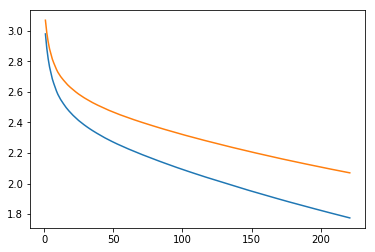

In [23]:
l = len(train_RMSEs)
x = np.linspace(1, l, l)
y1 = np.array(train_RMSEs)
y2 = np.array(valid_RMSEs)
plt.plot(x,y1)
plt.plot(x,y2)
plt.show()

In [31]:
len(valid_RMSEs)

225

In [38]:
train_RMSEs100 = []
valid_RMSEs100 = []

In [39]:
for latent in range(len(train_RMSEs100)+1, 37):
    U, Sigma, Vt = svds(Train_demeaned, k=latent*100)
    train_predicted_ratings = U @ np.diag(Sigma) @ Vt + train_mean.reshape(-1, 1)
    train_rmse100 = rmse2(train_predicted_ratings, Train)
    train_RMSEs100.append(train_rmse100)
    
    U, Sigma, Vt = svds(Valid_demeaned, k=latent*100)
    valid_predicted_ratings = U @ np.diag(Sigma) @ Vt + valid_mean.reshape(-1, 1)
    valid_rmse100 = rmse2(valid_predicted_ratings, Train)
    valid_RMSEs100.append(valid_rmse100)
    print(latent*100, train_rmse100, valid_rmse100)

100 2.092477201004958 2.320816872965534
200 1.8243135010944727 2.1076000141929607
300 1.605617802509003 1.9429807880835195
400 1.4195749292452722 1.810460823186422
500 1.2585803551643564 1.703184169040392
600 1.1177755307289907 1.6159660131326012
700 0.9935095212716408 1.5445133642038475
800 0.8837661689097757 1.4866789095467428
900 0.7862843303556379 1.4397279727757206
1000 0.6994999381295405 1.4016419081054188
1100 0.6215866718639029 1.3708296939155356
1200 0.5516765558948361 1.3460494125740259
1300 0.48893144706172725 1.3260895830802868


KeyboardInterrupt: 

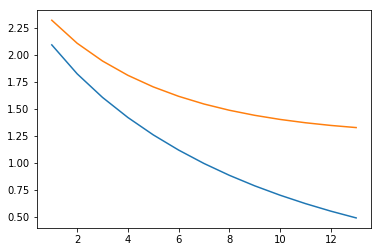

In [40]:
l = len(train_RMSEs100)
x = np.linspace(1, l, l)
y1 = np.array(train_RMSEs100)
y2 = np.array(valid_RMSEs100)
plt.plot(x,y1)
plt.plot(x,y2)
plt.show()

In [43]:
train_RMSEs400 = []
valid_RMSEs400 = []

In [44]:
for latent in range(len(train_RMSEs400)+1, 10):
    U, Sigma, Vt = svds(Train_demeaned, k=latent*400)
    train_predicted_ratings = U @ np.diag(Sigma) @ Vt + train_mean.reshape(-1, 1)
    train_rmse400 = rmse2(train_predicted_ratings, Train)
    train_RMSEs400.append(train_rmse400)
    
    U, Sigma, Vt = svds(Valid_demeaned, k=latent*400)
    valid_predicted_ratings = U @ np.diag(Sigma) @ Vt + valid_mean.reshape(-1, 1)
    valid_rmse400 = rmse2(valid_predicted_ratings, Train)
    valid_RMSEs400.append(valid_rmse400)
    print(latent*400, train_rmse400, valid_rmse400)

400 1.4195749292452726 1.810460823186422
800 0.8837661689097759 1.4866789095467428
1200 0.5516765558948361 1.3460494125740259
1600 0.33643410257094736 1.287618522117977
2000 0.1959828518298237 1.264879192187796
2400 0.10534876402205229 1.256896192482089
2800 0.04964560482522496 1.2545188090604278
3200 0.01704958569523731 1.2539588026288868


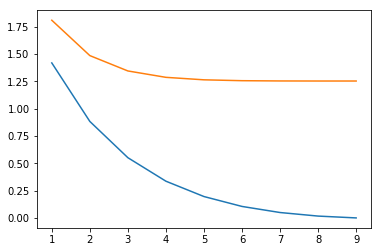

In [47]:
l = len(train_RMSEs400)
x = np.linspace(1, l, l)
y1 = np.array(train_RMSEs400)
y2 = np.array(valid_RMSEs400)
plt.plot(x,y1)
plt.plot(x,y2)
plt.show()

# Making Predictions from the Decomposed Matrices

Choose k=3600

In [80]:
# TODO: Construct approximation matrix.
U, Sigma, Vt = svds(R_demeaned, k=1000)
all_user_predicted_ratings = U @ np.diag(Sigma) @ Vt + user_ratings_mean.reshape(-1, 1)
all_user_predicted_ratings.shape

(6040, 3706)

# Making Movie Recommendations

In [81]:
# TODO: Recommend movies
preds_df = pd.DataFrame(all_user_predicted_ratings, columns=R_df.columns)
preds_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,5.024235,0.172952,-0.263437,0.264163,-0.055854,-0.003756,0.223074,-0.288130,-0.038512,-0.242340,...,-0.045897,-0.077010,0.035430,-0.163243,-0.009611,-0.047818,-0.091652,-0.091740,-0.010373,-0.260473
1,0.073449,0.125683,-0.129050,-0.053388,-0.185333,0.091745,-0.035772,0.140475,0.091124,0.245088,...,0.074072,0.004126,-0.091256,-0.013923,0.106963,-0.248704,0.209528,0.050319,-0.107476,-0.252240
2,-0.050107,0.035330,-0.148075,0.312336,-0.090883,0.095354,0.047567,-0.126916,-0.044202,0.240112,...,0.018785,-0.017970,0.073035,0.067730,0.105158,-0.013649,-0.075794,0.091027,0.025571,-0.106520
3,0.005422,0.068896,0.018007,-0.099098,0.035331,-0.009732,-0.006413,-0.033676,0.009348,-0.027698,...,-0.001948,0.041482,0.019219,-0.068268,0.002817,-0.093644,0.086854,0.066437,-0.021873,-0.143430
4,-0.067458,-0.772638,0.112880,0.142733,-0.072970,2.007176,-0.097757,0.016982,-0.064694,0.257765,...,0.148786,-0.033393,-0.115074,-0.144519,-0.186654,-0.118455,0.491966,-0.104889,-0.269868,-0.492710


In [82]:
# Recommend top five (num_recommendations) movies
# Return: Top five movies that user has already rated and top five recommend movies
def recommend_movies(predictions_df, userID, movies_df, original_ratings_df, num_recommendations=5):
    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) # UserID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.UserID==(userID)]
    # TODO
    user_full = user_data.copy()
    user_full = user_full.sort_values(by=['Rating', 'Timestamp'], ascending=False)
    user_full_head_values = user_full.head(5)['MovieID'].values
    #print(user_full_head_values)
    #print(user_full_head_values[0])
    user_top5 = movies_df.loc[movies_df['MovieID'] == user_full_head_values[0]]
    for i in user_full_head_values[1:]:
        user_top5 = user_top5.append(movies_df.loc[movies_df['MovieID'] == i])
    user_top5 = pd.concat([user_top5.reset_index(), user_full.head(5).reset_index()['Rating']], axis= 1).drop('index', axis=1)
    
    print('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    # TODO
    #print(type(sorted_user_predictions.index))
    #print(sorted_user_predictions)
    counter = 0
    recom = []
    watched = set(user_full['MovieID'].values)
    #print(sorted_user_predictions)
    for i in sorted_user_predictions.index:
        #print(i)
        if i not in watched:
            #print("not watched:", i)
            counter += 1
            recom.append(i)
        if counter>4:
            break
            
    recommendations = movies_df.loc[movies_df['MovieID'] == recom[0]]
    for i in recom[1:]:
        recommendations = recommendations.append(movies_df.loc[movies_df['MovieID'] == i])
    return user_top5, recommendations.reset_index().drop('index', axis=1)

In [83]:
already_rated, predictions = recommend_movies(preds_df, 69, movies_df, ratings_df, 10)

User 69 has already rated 65 movies.
Recommending highest 10 predicted ratings movies not already rated.


In [84]:
already_rated.head(5)

,MovieID,Title,Genres,Rating
0,1120,"People vs. Larry Flynt, The (1996)",Drama,5
1,321,Strawberry and Chocolate (Fresa y chocolate) (...,Drama,5
2,617,"Flower of My Secret, The (La Flor de Mi Secret...",Drama,5
3,1834,"Spanish Prisoner, The (1997)",Drama|Thriller,5
4,1810,Primary Colors (1998),Drama,5


In [85]:
predictions

,MovieID,Title,Genres
0,281,Nobody's Fool (1994),Drama
1,358,Higher Learning (1995),Drama
2,1633,Ulee's Gold (1997),Drama
3,2403,First Blood (1982),Action
4,205,Unstrung Heroes (1995),Comedy|Drama


# Questions

Q1: Please plot the change of cost (RMSE or SSE) respect to latent.

latent:1~221

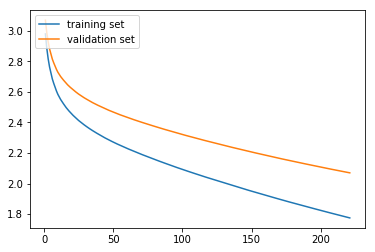

In [52]:
l = len(train_RMSEs)
x = np.linspace(1, l, l)
y1 = np.array(train_RMSEs)
y2 = np.array(valid_RMSEs)
plt.plot(x,y1, label='training set')
plt.plot(x,y2, label='validation set')
plt.legend(loc=2)
plt.show()

latent:100~1300

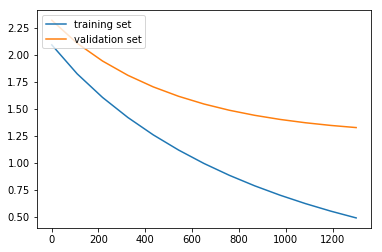

In [56]:
l = len(train_RMSEs100)
x = np.linspace(1, l*100, l)
y1 = np.array(train_RMSEs100)
y2 = np.array(valid_RMSEs100)
plt.plot(x,y1, label='training set')
plt.plot(x,y2, label='validation set')
plt.legend(loc=2)
plt.show()

latent:400~3600

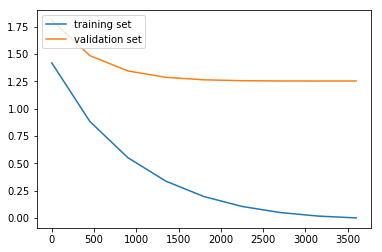

In [55]:
l = len(train_RMSEs400)
x = np.linspace(1, l*400, l)
y1 = np.array(train_RMSEs400)
y2 = np.array(valid_RMSEs400)
plt.plot(x,y1, label='training set')
plt.plot(x,y2, label='validation set')
plt.legend(loc=2)
plt.show()

Q2: What is the best latent?

In [87]:
for i in range(9):
    print(i*400, train_RMSEs400[i], valid_RMSEs400[i])

0 1.4195749292452726 1.810460823186422
400 0.8837661689097759 1.4866789095467428
800 0.5516765558948361 1.3460494125740259
1200 0.33643410257094736 1.287618522117977
1600 0.1959828518298237 1.264879192187796
2000 0.10534876402205229 1.256896192482089
2400 0.04964560482522496 1.2545188090604278
2800 0.01704958569523731 1.2539588026288868
3200 0.00027766814692881613 1.2539049494586747


根據validation set 的結果來看，latent 越大 RMSE 越小，但是超過1000以後幾乎只有微小變化。
考慮到效率選用latent=1000為最後結果。

Q3: Please randomly choose five users from your test sets and recommend 10 movies.

In [ ]:
Choose UserID: 13, 130, 1300, 3900, 87

In [64]:
users = [13, 130, 1300, 3900, 87]

# USER 1

In [88]:
already_rated, predictions = recommend_movies(preds_df, users[0], movies_df, ratings_df, 10)

User 13 has already rated 108 movies.
Recommending highest 10 predicted ratings movies not already rated.


In [89]:
already_rated.head(5)

,MovieID,Title,Genres,Rating
0,421,Black Beauty (1994),Adventure|Children's,5
1,1287,Ben-Hur (1959),Action|Adventure|Drama,5
2,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,5
3,1198,Raiders of the Lost Ark (1981),Action|Adventure,5
4,1204,Lawrence of Arabia (1962),Adventure|War,5


In [90]:
predictions

,MovieID,Title,Genres
0,1562,Batman & Robin (1997),Action|Adventure|Crime
1,3366,Where Eagles Dare (1969),Action|Adventure|War
2,849,Escape from L.A. (1996),Action|Adventure|Sci-Fi|Thriller
3,2471,Crocodile Dundee II (1988),Adventure|Comedy
4,208,Waterworld (1995),Action|Adventure


# USER 2

In [91]:
already_rated, predictions = recommend_movies(preds_df, users[1], movies_df, ratings_df, 10)

User 130 has already rated 135 movies.
Recommending highest 10 predicted ratings movies not already rated.


In [92]:
already_rated.head(5)

,MovieID,Title,Genres,Rating
0,2167,Blade (1998),Action|Adventure|Horror,5
1,3082,"World Is Not Enough, The (1999)",Action|Thriller,5
2,1101,Top Gun (1986),Action|Romance,5
3,2991,Live and Let Die (1973),Action,5
4,2393,Star Trek: Insurrection (1998),Action|Sci-Fi,5


In [93]:
predictions

,MovieID,Title,Genres
0,2990,Licence to Kill (1989),Action
1,2993,Thunderball (1965),Action
2,3929,"Bank Dick, The (1940)",Comedy
3,2376,"View to a Kill, A (1985)",Action
4,3029,Nighthawks (1981),Action|Drama


# USER 3

In [94]:
already_rated, predictions = recommend_movies(preds_df, users[2], movies_df, ratings_df, 10)

User 1300 has already rated 166 movies.
Recommending highest 10 predicted ratings movies not already rated.


In [95]:
already_rated.head(5)

,MovieID,Title,Genres,Rating
0,2060,BASEketball (1998),Comedy,5
1,2987,Who Framed Roger Rabbit? (1988),Adventure|Animation|Film-Noir,5
2,3114,Toy Story 2 (1999),Animation|Children's|Comedy,5
3,3176,"Talented Mr. Ripley, The (1999)",Drama|Mystery|Thriller,5
4,2700,"South Park: Bigger, Longer and Uncut (1999)",Animation|Comedy,5


In [96]:
predictions

,MovieID,Title,Genres
0,2279,Urban Legend (1998),Horror|Thriller
1,2315,Bride of Chucky (1998),Horror|Thriller
2,2447,Varsity Blues (1999),Comedy|Drama
3,2338,I Still Know What You Did Last Summer (1998),Horror|Mystery|Thriller
4,1983,Halloween II (1981),Horror


# USER 4

In [97]:
already_rated, predictions = recommend_movies(preds_df, users[3], movies_df, ratings_df, 10)

User 3900 has already rated 409 movies.
Recommending highest 10 predicted ratings movies not already rated.


In [98]:
already_rated.head(5)

,MovieID,Title,Genres,Rating
0,3753,"Patriot, The (2000)",Action|Drama|War,5
1,50,"Usual Suspects, The (1995)",Crime|Thriller,5
2,296,Pulp Fiction (1994),Crime|Drama,5
3,1393,Jerry Maguire (1996),Drama|Romance,5
4,1193,One Flew Over the Cuckoo's Nest (1975),Drama,5


In [99]:
predictions

,MovieID,Title,Genres
0,1007,"Apple Dumpling Gang, The (1975)",Children's|Comedy|Western
1,2072,"'burbs, The (1989)",Comedy
2,2378,Police Academy (1984),Comedy
3,276,Milk Money (1994),Comedy|Romance
4,2953,Home Alone 2: Lost in New York (1992),Children's|Comedy


# USER 5

In [100]:
already_rated, predictions = recommend_movies(preds_df, users[4], movies_df, ratings_df, 10)

User 87 has already rated 59 movies.
Recommending highest 10 predicted ratings movies not already rated.


In [101]:
already_rated.head(5)

,MovieID,Title,Genres,Rating
0,1610,"Hunt for Red October, The (1990)",Action|Thriller,5
1,3639,"Man with the Golden Gun, The (1974)",Action,5
2,2000,Lethal Weapon (1987),Action|Comedy|Crime|Drama,5
3,480,Jurassic Park (1993),Action|Adventure|Sci-Fi,5
4,733,"Rock, The (1996)",Action|Adventure|Thriller,5


In [102]:
predictions

,MovieID,Title,Genres
0,3635,"Spy Who Loved Me, The (1977)",Action
1,2951,"Fistful of Dollars, A (1964)",Action|Western
2,1754,Fallen (1998),Action|Mystery|Thriller
3,2993,Thunderball (1965),Action
4,1587,Conan the Barbarian (1982),Action|Adventure
